In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns 
import scipy.io
import librosa
import librosa.display
from glob import glob
import os
import tensorflow as tf
import IPython.display as ipd
import PIL

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def preprocess(file_path): 
    wav , sr = librosa.load(file_path,sr=16000)
    l=len(wav)
    wav = wav[:50000]
    zero_padding = tf.zeros([50000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram , l

In [4]:
GUITAR = os.path.join('Data', 'AudioEventDataset','train', 'acoustic_guitar','acoustic_guitar_2.wav')
GLASS = os.path.join('Data', 'AudioEventDataset','train', 'glass_breaking','glass_breaking_0.wav')

In [5]:
wave=librosa.load(GUITAR)
nwave=librosa.load(GLASS)

In [6]:
S=preprocess(GUITAR)

In [7]:
S[0].shape

TensorShape([1553, 257, 1])

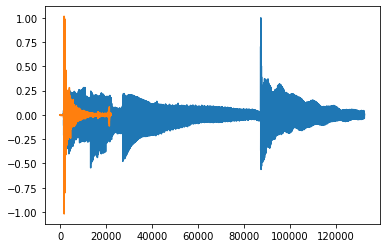

In [8]:
plt.plot(wave[0])
plt.plot(nwave[0])
plt.show()

In [9]:
GUITAR = os.path.join('Data', 'AudioEventDataset','train', 'acoustic_guitar')
#AIRPLANE = os.path.join('Data', 'AudioEventDataset','train', 'airplane')
APPLAUSE = os.path.join('Data', 'AudioEventDataset','train', 'applause')
#BIRD = os.path.join('Data', 'AudioEventDataset','train', 'bird')
KNOCK=os.path.join('Data','AudioEventDataset','train','knock')
GLASS = os.path.join('Data', 'AudioEventDataset','train', 'glass_breaking')
#CAT = os.path.join('Data', 'AudioEventDataset','train', 'cat')
#CHILD = os.path.join('Data', 'AudioEventDataset','train', 'child')
#WATER= os.path.join('Data', 'AudioEventDataset','train', 'water_tap')
#CROWD = os.path.join('Data', 'AudioEventDataset','train', 'crowd')
DOG = os.path.join('Data', 'AudioEventDataset','train', 'dog_barking')
VIOLIN = os.path.join('Data', 'AudioEventDataset','train', 'violin')

In [10]:
lengths = []
extracted_features =[]
for track in glob(os.path.join(GUITAR, '*.wav')):
    data,l=preprocess(track)
    extracted_features.append([data,"acoustic"])
    lengths.append(l)
    
#for track in glob(os.path.join(AIRPLANE, '*.wav')):
#    data,l=preprocess(track)
#    extracted_features.append([data,"airplane"])
#    lengths.append(l)
   
for track in glob(os.path.join(APPLAUSE, '*.wav')):
    data,l=preprocess(track)
    extracted_features.append([data,"applause"])
    lengths.append(l)
#
#for track in glob(os.path.join(GLASS, '*.wav')):
#    dadata,lta=preprocess(track)
#    extracted_features.append([data,"glass"])
#    lengths.append(l)

for track in glob(os.path.join(KNOCK, '*.wav')):
     data,l=preprocess(track)
     extracted_features.append([data,"knock"])
     lengths.append(l)

#for track in glob(os.path.join(CAT, '*.wav')):
#     data,l=preprocess(track)
#     extracted_features.append([data,"cat"])
#     lengths.append(l)
    
#for track in glob(os.path.join(CHILD, '*.wav')):
#    data,l=preprocess(track)
#    extracted_features.append([data,"child"])
#    lengths.append(l)
  
#for track in glob(os.path.join(WATER, '*.wav')):
#    data,l=preprocess(track)
#    extracted_features.append([data,"water"])
#    lengths.append(l)
    
#for track in glob(os.path.join(CROWD, '*.wav')):
#     data,l=preprocess(track)
#     extracted_features.append([data,"crowd"])
#     lengths.append(l)
    
for track in glob(os.path.join(DOG, '*.wav')):
    data,l=preprocess(track)
    extracted_features.append([data,"dog"])
    lengths.append(l)
    
for track in glob(os.path.join(VIOLIN, '*.wav')):
    data,l=preprocess(track)
    extracted_features.append([data,"violin"])
    lengths.append(l)

In [11]:
import random 
random.shuffle(extracted_features)

In [12]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['features','class'])
#extracted_features_df.head()

,features,class
0,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",applause
1,"(((tf.Tensor(0.19172058, shape=(), dtype=float...",dog
2,"(((tf.Tensor(0.037172973, shape=(), dtype=floa...",applause
3,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",violin
4,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",dog


In [13]:
#determine length 
#mean lengths of audio
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=119756>

In [14]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=15465>

In [15]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=281408>

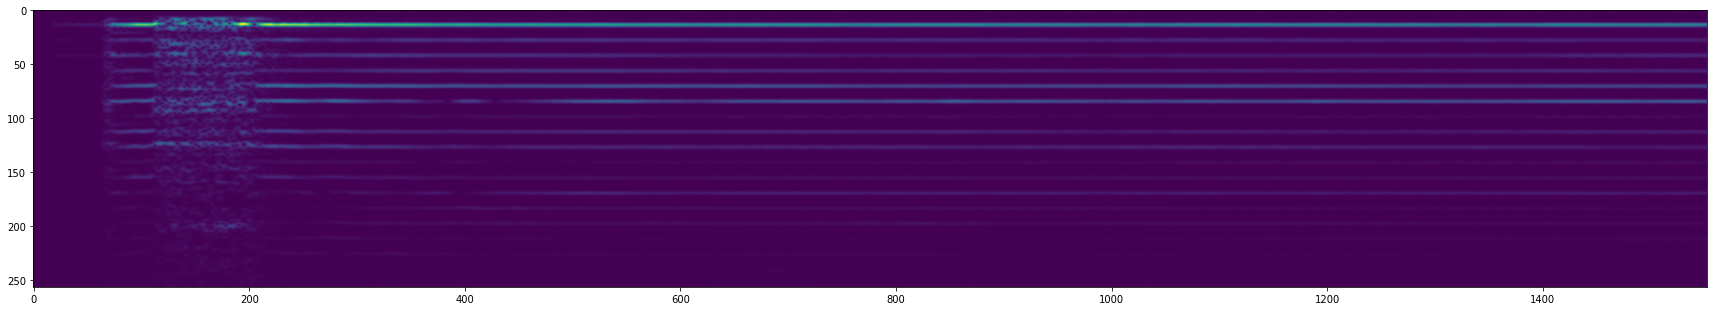

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(extracted_features_df['features'][3])[0])
plt.show()

In [17]:
extracted_features_df['class'][3]

'violin'

In [18]:
#split the dataset into independent and dependent dataset 
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [19]:
#label encoding 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [20]:
#splitting data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

In [21]:
#Number of classes
num_classes=y.shape[1]

In [22]:
X_train.shape

(501, 1553, 257, 1)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout ,Activation,Flatten , Conv2D , MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1553, 257,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1551, 255, 16)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 775, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 773, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 386, 62, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 382912)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               49012864  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [25]:
model.compile(loss='categorical_crossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],optimizer='adam')

In [26]:
##Training the model 
from datetime import datetime

num_epochs=10
num_batch_size=16
start = datetime.now()

hist=model.fit(X_train,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(X_test,y_test))
duration=datetime.now() - start 
print("Training completed in time :",duration)

Epoch 1/10
32/32 [==============================] - 11s 127ms/step - loss: 4.6701 - recall: 0.6327 - precision: 0.7188 - val_loss: 1.0232 - val_recall: 0.8254 - val_precision: 0.8739
Epoch 2/10
32/32 [==============================] - 3s 90ms/step - loss: 0.2249 - recall: 0.9182 - precision: 0.9563 - val_loss: 0.5997 - val_recall: 0.8889 - val_precision: 0.9032
Epoch 3/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0527 - recall: 0.9760 - precision: 0.9939 - val_loss: 0.7937 - val_recall: 0.8571 - val_precision: 0.9076
Epoch 4/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0179 - recall: 0.9940 - precision: 0.9980 - val_loss: 0.8069 - val_recall: 0.9206 - val_precision: 0.9431
Epoch 5/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0029 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.8624 - val_recall: 0.9206 - val_precision: 0.9280
Epoch 6/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0011 - recall: 1.0

In [27]:
#example 
example = "Data//AudioEventDataset//test//tracks/acoustic_guitar_103.wav"
prediction_features,_=preprocess(example)

#prediction_features=prediction_features.reshape(1,-1)
prediction_features=tf.expand_dims(prediction_features,axis=0)
prediction=model.predict(prediction_features)
#prediction_features.shape
prediction_features.shape

TensorShape([1, 1553, 257, 1])

In [28]:
predicted_class=np.argmax(prediction,axis=1)
prediction_class=labelencoder.inverse_transform(predicted_class)
prediction_class

array(['acoustic'], dtype='<U8')

In [29]:
#TEST the model on New Data
test_data_path=os.path.join('Data', 'AudioEventDataset','test', 'tracks')
testing_data =[]
for file in os.listdir(os.path.join(test_data_path)):
    FILEPATH=os.path.join(test_data_path,file)
    data,_=preprocess(FILEPATH)
    file=file.split("_")
    testing_data.append([data,file[0]])

In [30]:
testing_data=pd.DataFrame(testing_data,columns=['features','class'])
#testing_data.head()

,features,class
0,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",acoustic
1,"(((tf.Tensor(1.0249296, shape=(), dtype=float3...",acoustic
2,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",acoustic
3,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",acoustic
4,"(((tf.Tensor(0.0, shape=(), dtype=float32)), (...",acoustic


In [31]:
x_test_data=np.array(testing_data['features'].tolist())
y_test_data=np.array(testing_data['class'].tolist())
labelencoder=LabelEncoder()
y_test_data=to_categorical(labelencoder.fit_transform(y_test_data))

In [32]:
test_accuracy=model.evaluate(x_test_data,y_test_data)
test_accuracy[2]

7/7 [==============================] - 1s 58ms/step - loss: 0.3831 - recall: 0.9107 - precision: 0.9189


0.9189189076423645

In [33]:
test_accuracy

[0.3831403851509094, 0.9107142686843872, 0.9189189076423645]

In [34]:
hist.history

{'loss': [4.670108795166016,
  0.22489486634731293,
  0.052673183381557465,
  0.017921902239322662,
  0.002939988858997822,
  0.0010548400459811091,
  0.0003231514128856361,
  0.00018656469183042645,
  0.00012182893988210708,
  8.649782830616459e-05],
 'recall': [0.6327345371246338,
  0.9181636571884155,
  0.976047933101654,
  0.9940119981765747,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'precision': [0.7188208699226379,
  0.9563409686088562,
  0.9939024448394775,
  0.9979959726333618,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [1.0231698751449585,
  0.5996872186660767,
  0.7937267422676086,
  0.8069177269935608,
  0.8624175190925598,
  0.9445714950561523,
  0.9779646992683411,
  1.0307433605194092,
  1.0453293323516846,
  1.0671191215515137],
 'val_recall': [0.8253968358039856,
  0.8888888955116272,
  0.8571428656578064,
  0.920634925365448,
  0.920634925365448,
  0.9285714030265808,
  0.9285714030265808,
  0.920634925365448,
  0.9285714030265808,
  0.9285714030265808],

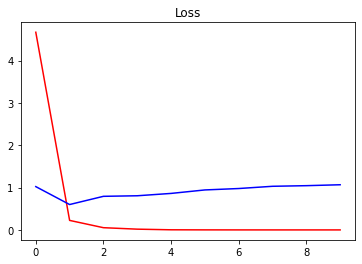

In [35]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

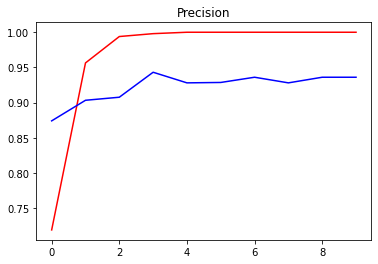

In [36]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()